# Training IMDB with Huggingface preprocessed distilbert

With examples from: 

- https://huggingface.co/docs/transformers/tasks/sequence_classification
- https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator
- https://medium.com/@dhartidhami/understanding-bert-word-embeddings-7dc4d2ea54ca
- https://www.kaggle.com/code/satyampd/imdb-sentiment-analysis-using-bert-w-huggingface/notebook


In [136]:
import pandas

# data from https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb_data = pandas.read_csv('IMDB Dataset.csv')
imdb_data.sample()

,review,sentiment
3401,Four stories written by Robert Bloch about var...,positive


In [137]:
import pandas as pd

def convert_label(data, label_col):
    data[label_col] = data[label_col].apply(lambda x: 1 if x == 'positive' else 0)

    return data
pd.options.display.max_rows = 1000
data_preproc = convert_label(imdb_data, 'sentiment')
data_preproc.sample(120)

,review,sentiment
11837,Just in time to capitalize on the long-awaited...,0
15661,Full disclosure: I was born in 1967. At first ...,0
19246,This is the best version of Gypsy that has bee...,1
31733,"Stan Laurel, it's been noted, first made a rea...",1
11619,It seemed as though the year 1984 was anything...,1
47431,Few movies have dashed expectations and upset ...,0
45382,"As I have said before in previous comments, so...",1
27034,This movie is bad.<br /><br />This movie is RE...,0
2200,"I finally caught up to ""Starlight"" last night ...",0
45459,Paha maa is different Finnish film. But the th...,1


In [138]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def convert_tokenize(dataset):
    return dataset['review'].apply(lambda x: tokenizer(x, truncation=True, padding='max_length', max_length=128))

data_tokenized = convert_tokenize(data_preproc[:1000])
data_tokenized.sample()

730    [input_ids, attention_mask]
Name: review, dtype: object

In [139]:
from sklearn.model_selection import train_test_split

train_tok, val_tok = train_test_split(data_tokenized, test_size=0.33, shuffle=True)

In [140]:
import tensorflow as tf
import pandas as pd
from tqdm import tqdm 

def convert_to_tfdata(data):
    def gen():
        for i, d in data.iteritems():
            yield ({
                'input_ids': d['input_ids'],
                'attention_mask': d['attention_mask'],
            }, data_preproc.loc[i]['sentiment'])

    return tf.data.Dataset.from_generator(
            gen, 
            ({'input_ids': tf.int32, 'attention_mask': tf.int32}, tf.int64),
            ({'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None])}, tf.TensorShape([])),
    )

train = convert_to_tfdata(train_tok).batch(32)
val = convert_to_tfdata(val_tok).batch(32)
    

In [141]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-8, clipnorm=1.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_157', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

In [160]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_157 (Dropout)       multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 66,955,010
Non-trainable params: 0
_________________________________________________________________


In [119]:
print(train)
print(val)

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [142]:
history = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2
21/21 [==============================] - 124s 6s/step - loss: 0.6539 - accuracy: 0.6358 - val_loss: 0.5509 - val_accuracy: 0.7364
Epoch 2/2
21/21 [==============================] - 117s 6s/step - loss: 0.3931 - accuracy: 0.8403 - val_loss: 0.3701 - val_accuracy: 0.8333


{'loss': [0.6538740992546082, 0.39309725165367126], 'accuracy': [0.6358209252357483, 0.8402985334396362], 'val_loss': [0.5508712530136108, 0.3701034486293793], 'val_accuracy': [0.7363636493682861, 0.8333333134651184]}


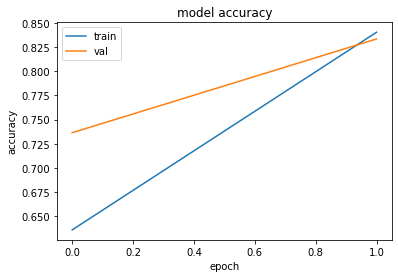

In [143]:
from matplotlib import pyplot as plt

print(history.history)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [144]:
model.save('training-100.tf')

INFO:tensorflow:Assets written to: training-100.tf/assets


INFO:tensorflow:Assets written to: training-100.tf/assets


In [158]:
#pred_sentences = imdb_data.loc[:5, 'review'].values

#print(pred_sentences, type(pred_sentences))

pred_sentences = [
   "I have read all of Tom Holland's non-fiction except for 'Dynasty', and have liked and learned something from it all. Not so here: unlike what's written on the cover, this work is not much about the making of the Western mind - at least not in the way that books like 'The Unintended Reformation', 'A Secular Age', and others are. It is a decent, but not first-rate, social history of Christianity in one volume from an agnostic-atheist standpoint, with space constraints leading to superficial coverage and a questionable selection of events to cover vignette-style.",
   'Movie is ok. I enjoyed it in the theatre. Very entertaining story plot and acting. The performance from Robert Downey Jr is just superb.',
    'The movie is ok I guess. Something nice to go with popcorn and stuff.',
    "The central thesis of this book devolves into the Goodness Gracious Me sketch about the Indian father. Everyone was Christian! Diderot? Christian! Voltaire? Christian! Karl Marx? Christian! Charlie Hebdo? Christian! (The Nazis were not Christian, but) Harvey Weinstein (yes, really)? Christian! The Women's March? Christian! It is almost always asserted rather than argued for properly, and it makes the last third of the book very dull indeed.",
    " Tom Holland has a great easy to read writing style, but the argument in this book was ... not his finest. The first half that explores the origins of Christian ideas and the growth / making of the Catholic Church is very interesting. Well researched, well told. I found the connections between Persian religious tradition and early Christianity especially compelling. ",
    " It's not the first book on Systems Theory I've read, but even if this one is described as a primer, it was not time wasted (definitely).",
]

tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
print(tf_predictions)

labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])

tf.Tensor(
[[0.64929    0.35070994]
 [0.06458809 0.9354119 ]
 [0.3883741  0.6116259 ]
 [0.8960868  0.1039132 ]
 [0.07009995 0.92990005]
 [0.7813548  0.21864523]], shape=(6, 2), dtype=float32)
I have read all of Tom Holland's non-fiction except for 'Dynasty', and have liked and learned something from it all. Not so here: unlike what's written on the cover, this work is not much about the making of the Western mind - at least not in the way that books like 'The Unintended Reformation', 'A Secular Age', and others are. It is a decent, but not first-rate, social history of Christianity in one volume from an agnostic-atheist standpoint, with space constraints leading to superficial coverage and a questionable selection of events to cover vignette-style. :  Negative
Movie is ok. I enjoyed it in the theatre. Very entertaining story plot and acting. The performance from Robert Downey Jr is just superb. :  Positive
The movie is ok I guess. Something nice to go with popcorn and stuff. :  Positiv

In [159]:
pred_sentences = [
    'Movie is ok. I enjoyed it in the theatre. Very entertaining story plot and acting. The performance from Robert Downey Jr is just superb.',
    'The movie is ok I guess. Something nice to go with popcorn and stuff.',
    'Was expecting something better. Passed out sleeping half way of the movie',
]

tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
print(tf_predictions)

labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", labels[label[i]])

tf.Tensor(
[[0.06458809 0.9354119 ]
 [0.3883741  0.6116259 ]
 [0.80787677 0.19212317]], shape=(3, 2), dtype=float32)
Movie is ok. I enjoyed it in the theatre. Very entertaining story plot and acting. The performance from Robert Downey Jr is just superb. :  Positive
The movie is ok I guess. Something nice to go with popcorn and stuff. :  Positive
Was expecting something better. Passed out sleeping half way of the movie :  Negative
